# Sample standardized multivariate normal distribution using Cholesky decomposition.

In [25]:
from jax import jit, vmap, hessian
import jax.numpy as jnp
import jax.random as jr
from jax.lax import cond
from jax.scipy.stats import multivariate_normal
import numpyro
from numpyro.infer import NUTS, MCMC
from numpyro.distributions import Uniform, Normal
import numpy as np
import matplotlib.pyplot as plt
from emcee.autocorr import integrated_time
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

In [2]:
# load samplers
import sys
import os

cwd = os.getcwd()
project_root = os.path.abspath(os.path.join(cwd, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from samplers.ptmcmc import ptmcmc_sampler

## Prior, likelihood, and posterior formulation

We use a uniform prior over parameters $\mathbf{x}$. The likelihood is a multivariate Gaussian,

\begin{equation}
    p(\boldsymbol{\mu}, \boldsymbol{\Sigma}|\mathbf{x}) = \frac{1}{\sqrt{\text{det}(2\pi\boldsymbol{\Sigma})}}\;\text{exp}\bigg[-\frac{1}{2}(\mathbf{x}-\boldsymbol{\mu})^\text{T}\,\boldsymbol{\Sigma}^{-1}\,(\mathbf{x}-\boldsymbol{\mu})\bigg]\;.
\end{equation}

In [4]:
# parameter bounds
ndim = 8
x_mins = jnp.array([-10.] * ndim)
x_maxs = jnp.array([10.] * ndim)

# moments of normal distribution
x_mean = jr.uniform(jr.key(0), (ndim,), minval=x_mins/2., maxval=x_maxs/2.)
x_normal = jr.normal(jr.key(1), (ndim,))
x_cov = jnp.outer(x_normal, x_normal) + jnp.eye(ndim) * 0.1
vals, vecs = jnp.linalg.eigh(x_cov)

# parameter labels
x_labels = np.array([rf'$x_{{{i}}}$' for i in range(ndim)])

# uniform prior
def lnprior(x):
    out_of_bounds = jnp.logical_or(jnp.any(x < x_mins),
                                   jnp.any(x > x_maxs))
    def out_of_bounds_case():
        return -jnp.inf
    def in_bounds_case():
        return 0.
    return cond(out_of_bounds, out_of_bounds_case, in_bounds_case)
fast_lnprior = jit(lnprior)

In [5]:
# likelihood
def lnlike(x):
    return multivariate_normal.logpdf(x, x_mean, x_cov)
fast_lnlike = jit(lnlike)

In [6]:
# posterior
def lnpost(x):
    return fast_lnprior(x) + fast_lnlike(x)
fast_lnpost = jit(lnpost)
vectorized_lnpost = jit(vmap(fast_lnpost))

## Sample with HMC using NUTS

In [7]:
def sampling_model():
    x = jnp.array([numpyro.sample(x_label, Uniform(x_min, x_max))
                   for x_label, x_min, x_max in zip(x_labels, x_mins, x_maxs)])
    numpyro.factor('log_likelihood', fast_lnlike(x))

In [8]:
# do HMC with NUTS
num_samples = int(1e5)
num_warmup = 1000

nuts_kernel = NUTS(sampling_model)
mcmc = MCMC(nuts_kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(jr.key(1))
samples_dict = mcmc.get_samples()

# convert dictionary of samples to array
HMC_samples = np.array([samples_dict[x_label] for x_label in x_labels]).T

sample: 100%|██████████| 101000/101000 [00:27<00:00, 3660.08it/s, 15 steps of size 1.89e-01. acc. prob=0.91]


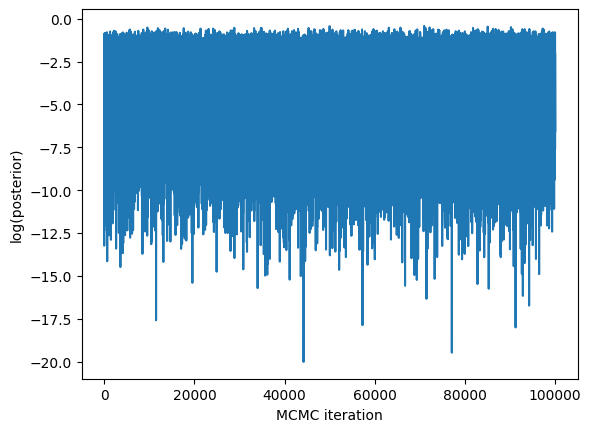

In [9]:
# plot likelihood values
HMC_lnposts = vectorized_lnpost(HMC_samples)
plt.plot(HMC_lnposts)
plt.xlabel('MCMC iteration')
plt.ylabel('log(posterior)')
plt.show()

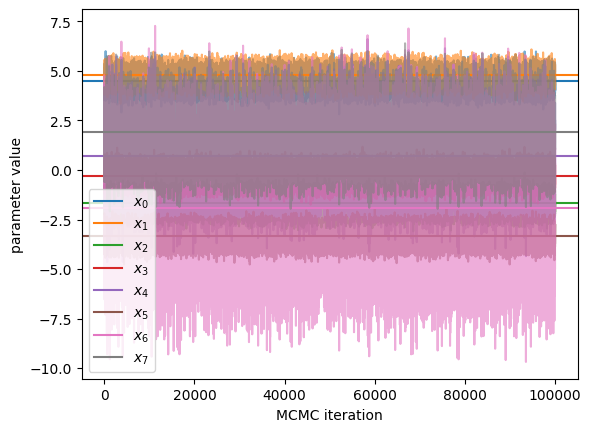

In [10]:
# trace plot
for i in range(ndim):
    plt.plot(HMC_samples[:, i], color=f'C{i}', alpha=0.6)
    plt.axhline(x_mean[i], color=f'C{i}', label=x_labels[i])
plt.xlabel('MCMC iteration')
plt.ylabel('parameter value')
plt.legend()
plt.show()

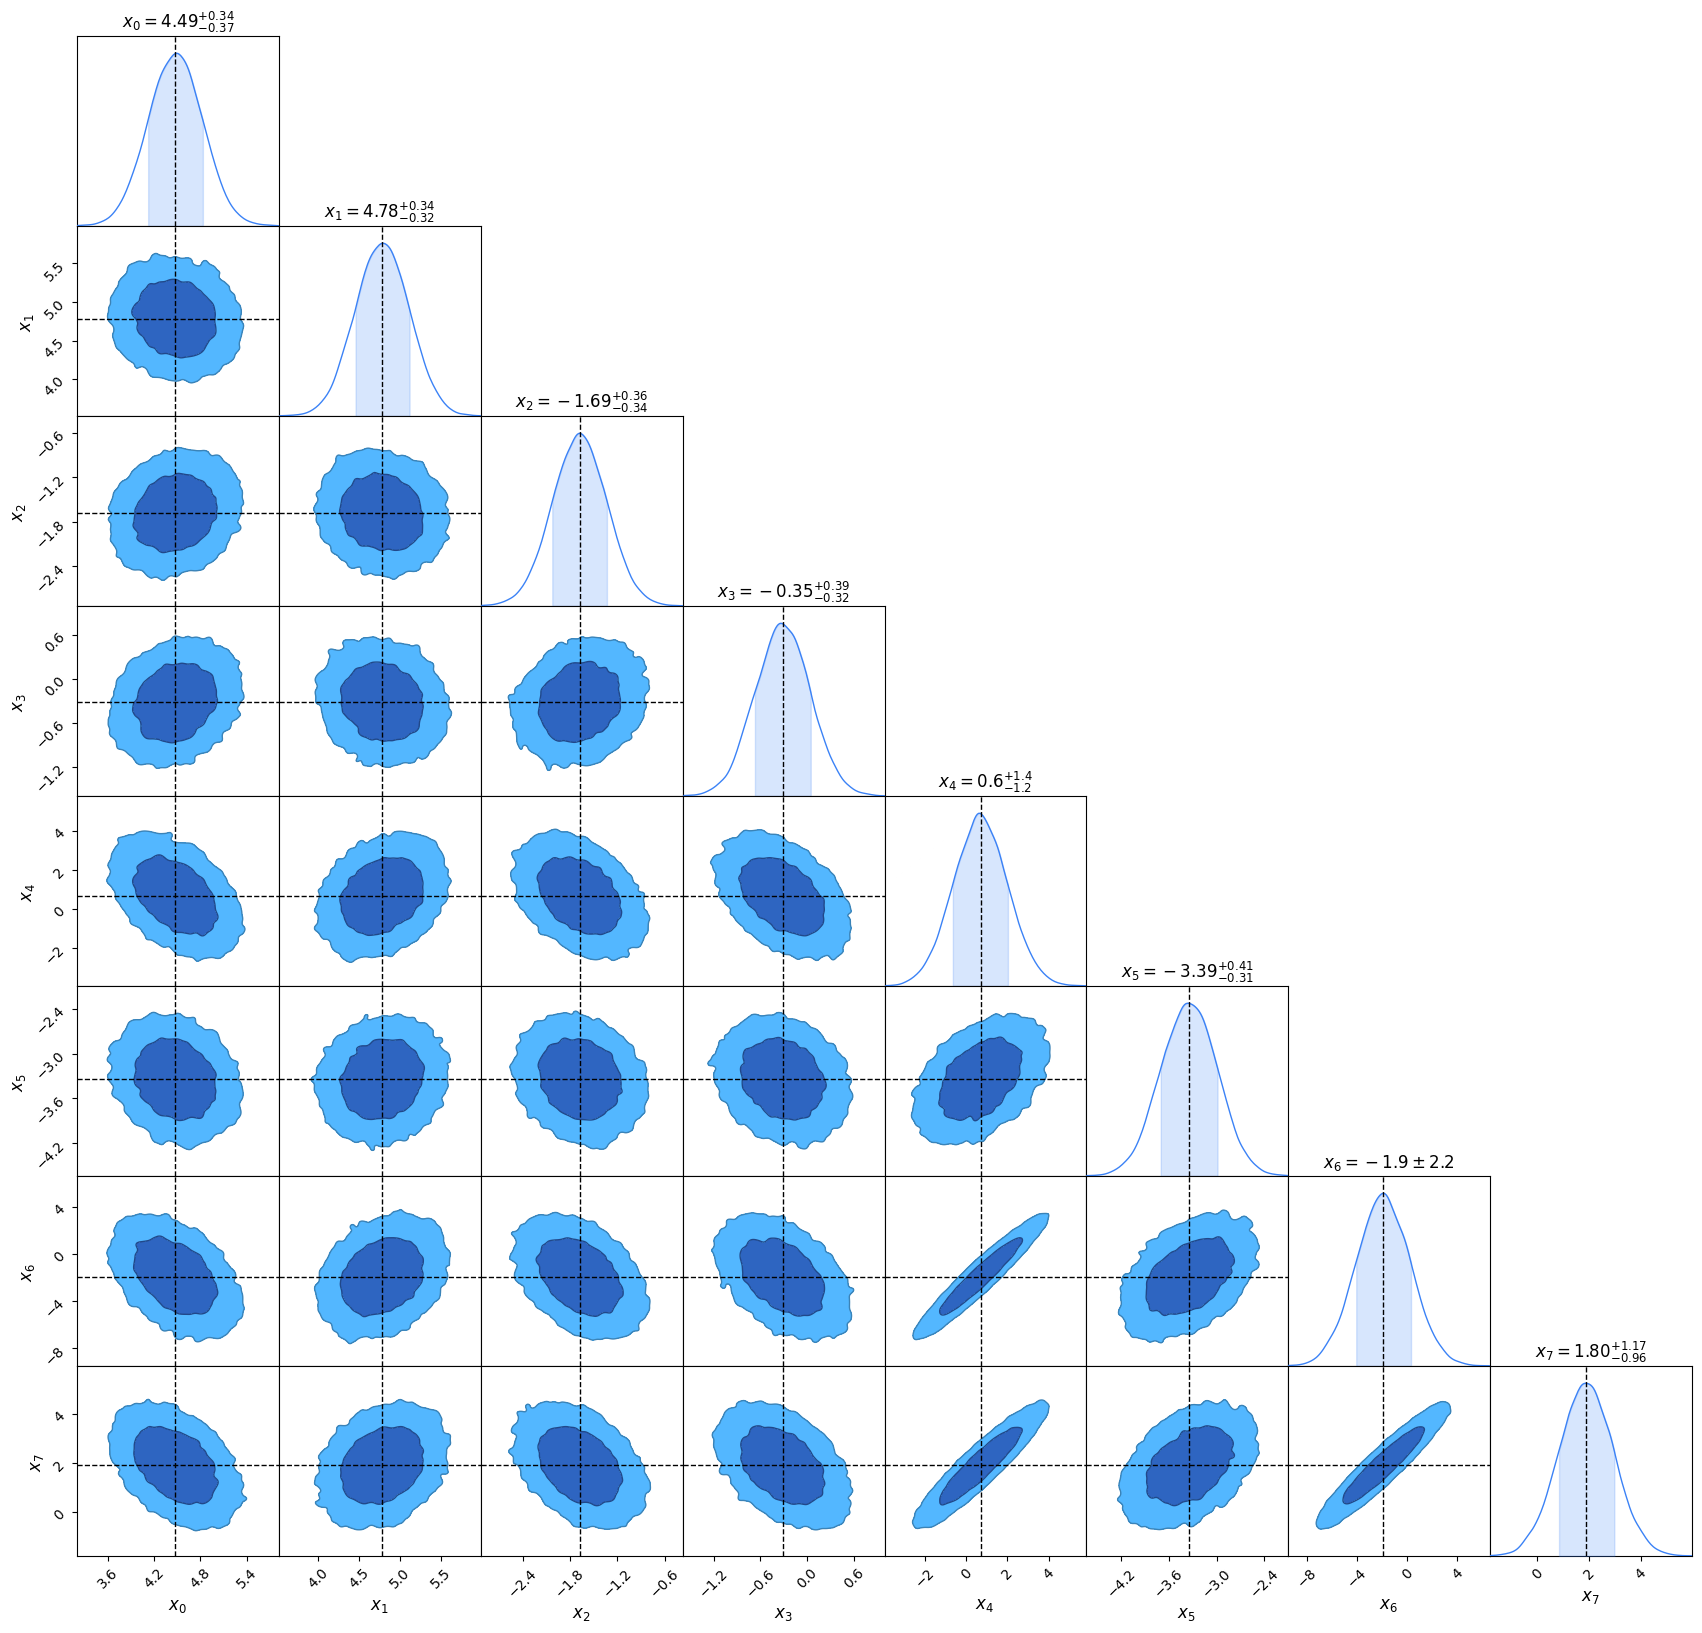

In [11]:
# plot posterior
burnin = num_samples // 10
auto_correlation = int(np.round(integrated_time(HMC_samples[burnin:])[0]))
df = pd.DataFrame(HMC_samples[burnin::auto_correlation], columns=x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='HMC'))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels, x_mean)}))
fig = c.plotter.plot()

## Sample with PTMCMC

In [12]:
# posterior function with temperature input
def lnpost_pt(x, temperature=1.0):
    return fast_lnpost(x) / temperature
fast_lnpost_pt = jit(lnpost_pt)

In [13]:
num_samples = int(1e6)
num_chains = 20
samples, lnposts, temp_ladder = ptmcmc_sampler(num_samples,
                                               num_chains,
                                               fast_lnpost_pt,
                                               x_mean,
                                               x_mins=x_mins,
                                               x_maxs=x_maxs,
                                               Fisher_jump_weight=20,
                                               DE_jump_weight=20,
                                               PT_swap_weight=20,
                                               seed=0)

jump acceptance rates

Fisher: [0.592      0.643      0.68600005 0.726      0.763      0.79600006
 0.827      0.85200006 0.874      0.89400005 0.9110001  0.92300004
 0.933      0.94000006 0.94500005 0.94900006 0.95100003 0.95300007
 0.95300007 0.95400006]

DE: [0.09100001 0.105      0.123      0.14400001 0.16600001 0.193
 0.223      0.25300002 0.286      0.321      0.351      0.377
 0.397      0.41000003 0.41700003 0.42100003 0.42000002 0.416
 0.41500002 0.41200003]

PT swap: [0.58100003 0.578      0.58400005 0.591      0.59400004 0.6
 0.60300004 0.60700005 0.615      0.62100005 0.637      0.65400004
 0.68       0.717      0.76100004 0.809      0.85600007 0.897
 0.92800003        nan]



In [14]:
# transpose samples and posterior values so (num_chains, num_samples,)
samples = np.transpose(samples, (1, 0, 2))
lnposts = np.transpose(lnposts, (1, 0))
print(samples.shape)

(20, 1000000, 8)


In [15]:
auto_correlation = integrated_time(samples[0])
effective_sample_size = samples[0].shape[0] // auto_correlation
print(f'auto-correlation = {auto_correlation}')
print(f'effective sample size = {effective_sample_size}')

auto-correlation = [91.68453374]
effective sample size = [10906.]


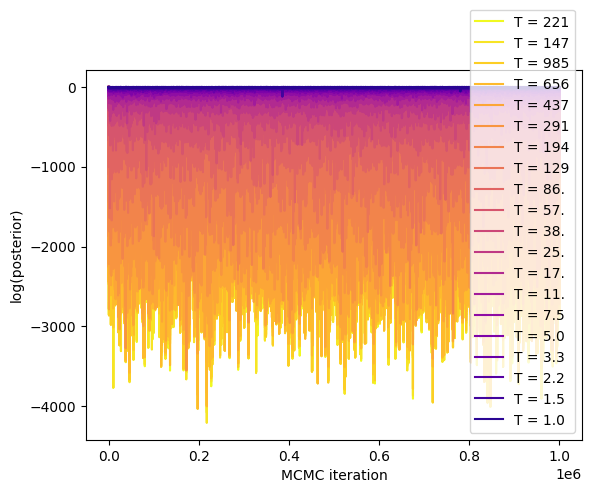

In [16]:
# plot likelihood values of chains (without temperature scaling)
chain_colors = list(reversed([plt.cm.plasma(i / num_chains) for i in range(1, num_chains + 1)]))

for j, (temp, color) in enumerate(zip(temp_ladder[::-1], chain_colors)):
    plt.plot(lnposts[::-1][j] * temp, color=color, label=f'T = {str(temp)[:3]}')
plt.xlabel('MCMC iteration')
plt.ylabel('log(posterior)')
plt.legend(loc='lower right')
plt.show()

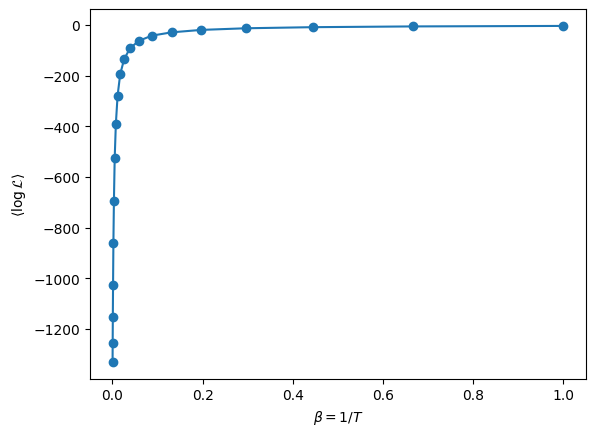

In [17]:
# average log-likelood over temperatures
burnin = num_samples // 5
avg_lnlikes = np.mean(lnposts[:, burnin::int(auto_correlation[0])], axis=1) * temp_ladder
betas = 1. / temp_ladder
plt.plot(betas, avg_lnlikes, marker='o')
plt.xlabel(r'$\beta = 1 / T$')
plt.ylabel(r'$\langle\log\mathcal{L}\rangle$')
plt.show()

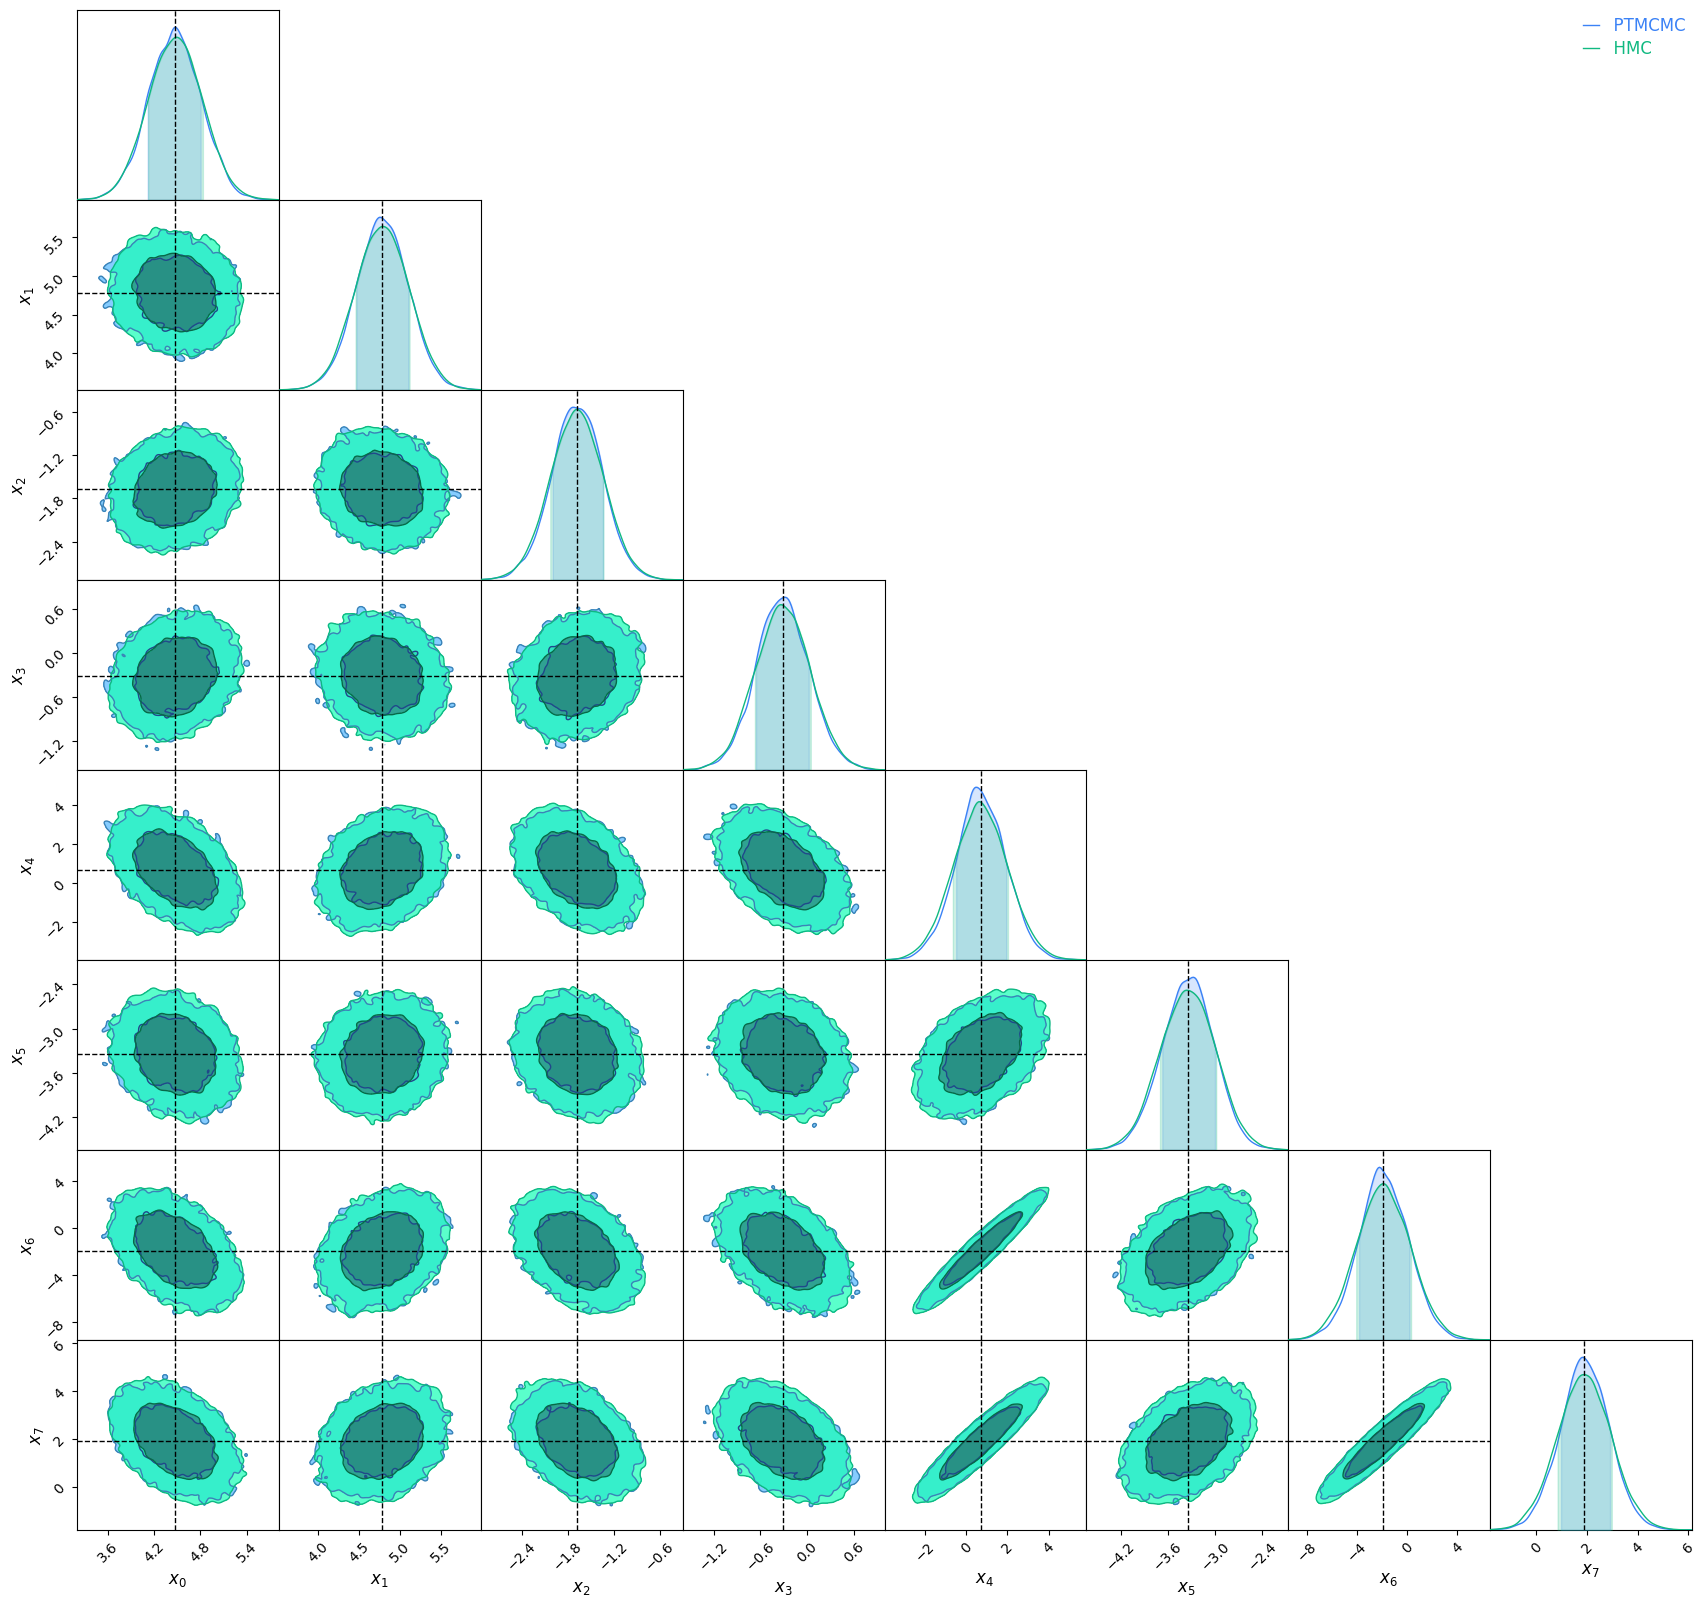

In [18]:
df_ptmcmc = pd.DataFrame(samples[0, burnin::int(auto_correlation[0])], columns=x_labels)

c = ChainConsumer()
c.add_chain(Chain(samples=df_ptmcmc, name='PTMCMC'))
c.add_chain(Chain(samples=df, name='HMC'))
c.add_truth(Truth(location={x_label: x_val for x_label, x_val in zip(x_labels, x_mean)}))
fig = c.plotter.plot(range)

## Sample from standardized distribution

In [19]:
L = jnp.linalg.cholesky(x_cov, upper=False)
def standard_lnpost(z):
    # transform back to unstandard coordinates
    x = x_mean + L @ z
    return fast_lnpost(x)
fast_standard_lnpost = jit(standard_lnpost)
vectorized_standard_lnpost = jit(vmap(fast_standard_lnpost))

z_labels = np.array([rf'$z_{{{i}}}$' for i in range(ndim)])
z_mins = jnp.array([-10.] * ndim)
z_maxs = jnp.array([10.] * ndim)

def standard_lnpost_pt(z, temperature=1.0):
    return fast_standard_lnpost(z) / temperature
fast_standard_lnpost_pt = jit(standard_lnpost_pt)

In [20]:
def standard_sampling_model():
    z = jnp.array([numpyro.sample(z_label, Uniform(z_min, z_max))
                   for z_label, z_min, z_max in zip(z_labels, z_mins, z_maxs)])
    numpyro.factor('log_likelihood', fast_standard_lnpost(z))

In [21]:
# sample with HMC
num_samples = int(1e4)
num_warmup = 1000

nuts_kernel_standard = NUTS(standard_sampling_model)
mcmc = MCMC(nuts_kernel_standard, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(jr.key(0))
standard_samples = mcmc.get_samples()
standard_samples = np.array([standard_samples[z_label] for z_label in z_labels]).T

sample: 100%|██████████| 11000/11000 [00:02<00:00, 3710.81it/s, 7 steps of size 7.11e-01. acc. prob=0.89]


In [22]:
# sample with PTMCMC
pt_samples, lnposts, temp_ladder = ptmcmc_sampler(num_samples=int(1e6),
                                                  num_chains=30,
                                                  logpdf_func=fast_standard_lnpost_pt,
                                                  x0=jnp.zeros(ndim),
                                                  x_mins=z_mins,
                                                  x_maxs=z_maxs,
                                                  DE_jump_weight=3)
pt_samples = np.transpose(pt_samples, (1, 0, 2))

jump acceptance rates

Fisher: [0.70500004 0.754      0.794      0.82800007 0.85700005 0.87900007
 0.896      0.9110001  0.92200005 0.93000007 0.93700004 0.94200003
 0.94500005 0.947      0.94600004 0.94400007 0.94100004 0.93900007
 0.938      0.93700004 0.93600005 0.93500006 0.934      0.934
 0.933      0.933      0.934      0.933      0.933      0.933     ]

DE: [0.072      0.082      0.09900001 0.119      0.142      0.16600001
 0.192      0.21800001 0.24800001 0.277      0.30600002 0.32900003
 0.344      0.36       0.363      0.36400002 0.36200002 0.36
 0.35900003 0.35300002 0.35300002 0.35900003 0.34800002 0.34800002
 0.349      0.35000002 0.349      0.349      0.35200003 0.35000002]

PT swap: [0.582      0.582      0.58500004 0.58900005 0.592      0.601
 0.60800004 0.60800004 0.61       0.624      0.63600004 0.656
 0.684      0.71800005 0.76100004 0.81000006 0.85700005 0.896
 0.92800003 0.95100003 0.966      0.97700006 0.9850001  0.99000007
 0.99300003 0.99500006 0.99700004 0.998 

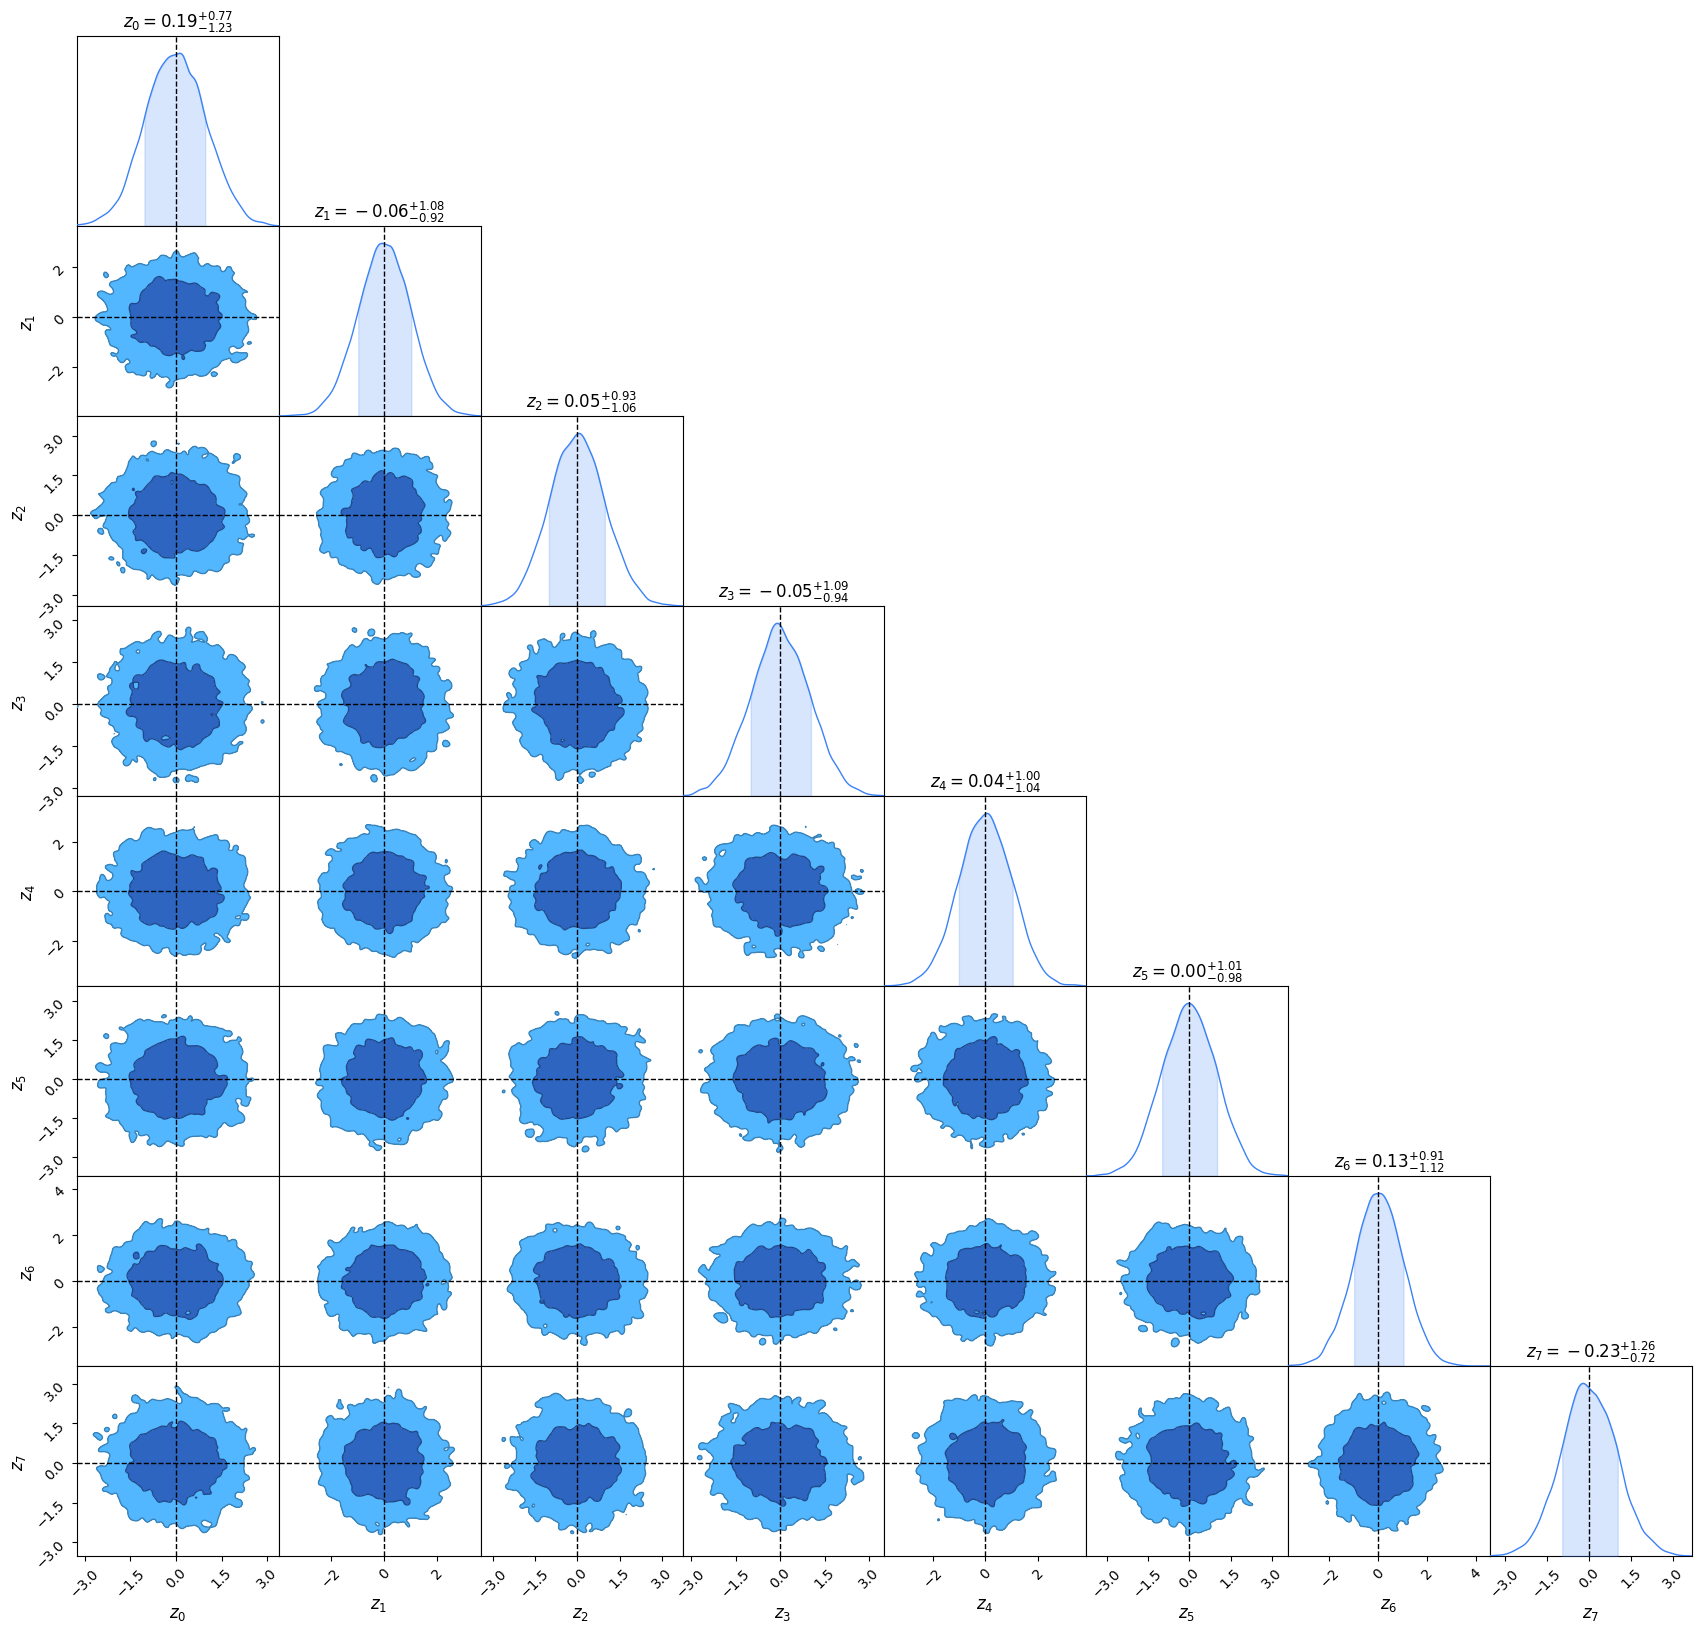

In [23]:
# plot standard normal distribution
burnin = num_samples // 10
auto_correlation = int(np.round(integrated_time(standard_samples)[0]))
df_standard = pd.DataFrame(standard_samples[burnin::auto_correlation], columns=z_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df_standard, name='HMC'))
c.add_truth(Truth(location={name: val for name, val in zip(z_labels, np.zeros(ndim))}))
fig = c.plotter.plot()

auto_correlation = 46


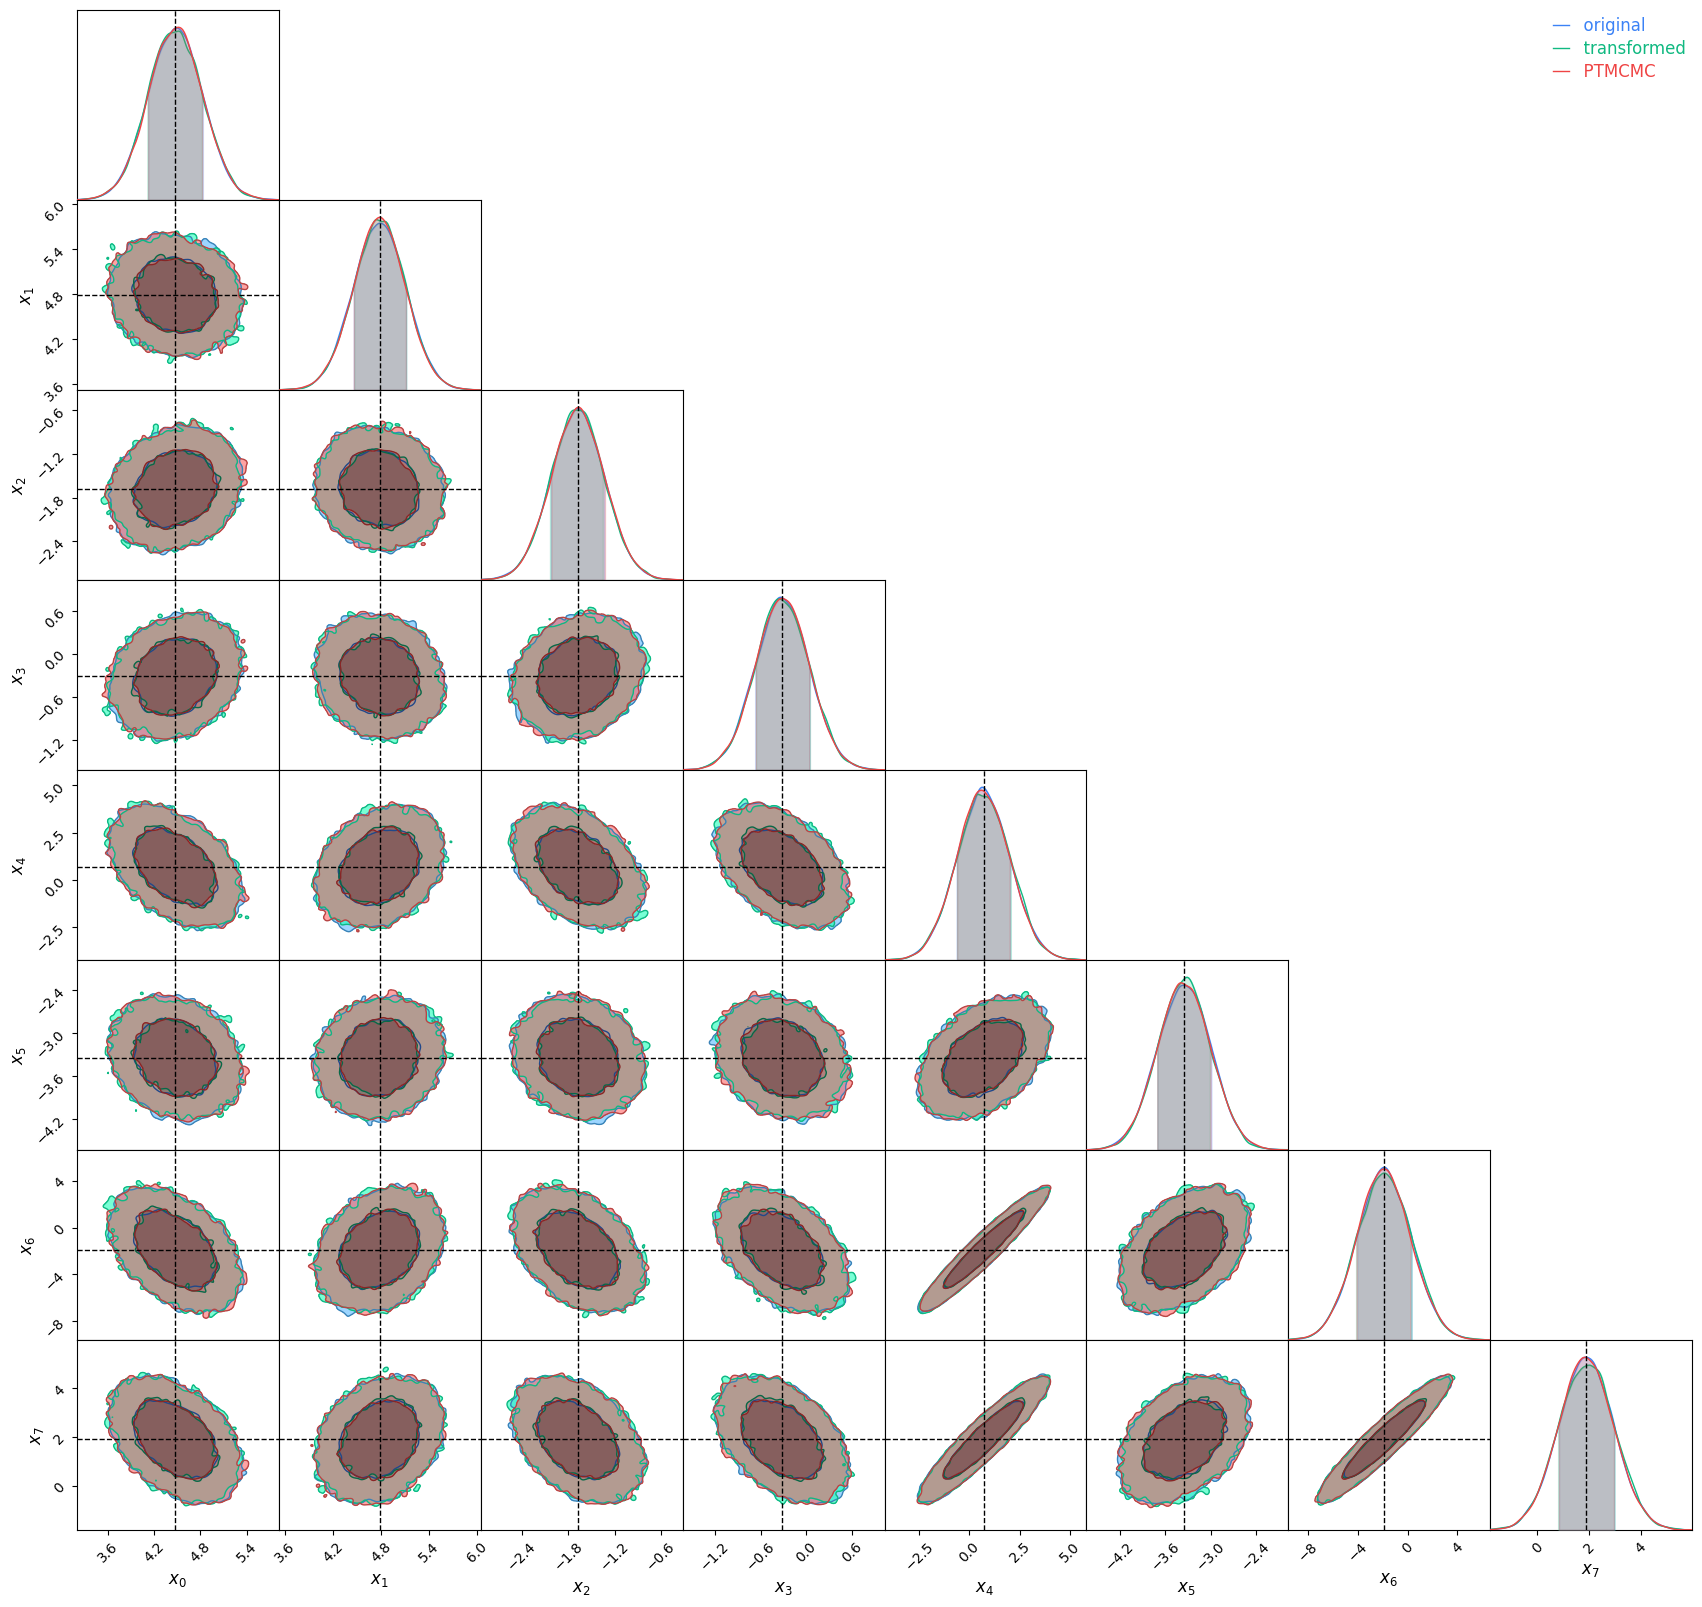

In [24]:
# transform samples back to original distribution
unstandard_samples = (x_mean[:, None] + L @ standard_samples.T).T
df_unstandard = pd.DataFrame(unstandard_samples, columns=x_labels)

unstandard_pt_samples = (x_mean[:, None] + L @ pt_samples[0].T).T
auto_correlation = int(np.round(integrated_time(unstandard_pt_samples[pt_samples.shape[0]//2:])[0]))
print(f'auto_correlation = {auto_correlation}')
df_unstandard_pt = pd.DataFrame(unstandard_pt_samples[pt_samples.shape[0]//10::auto_correlation], columns=x_labels)

c = ChainConsumer()
c.add_chain(Chain(samples=df, name='original'))
c.add_chain(Chain(samples=df_unstandard, name='transformed'))
c.add_chain(Chain(samples=df_unstandard_pt, name='PTMCMC'))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels, x_mean)}))
fig = c.plotter.plot()

## Testing standardized sampling

In [30]:
def test_standard_sampling_model():
    x_standard = numpyro.sample('x_standard', Normal(loc=jnp.zeros(ndim), scale=jnp.ones(ndim)))
    x = x_mean + L @ x_standard
    numpyro.deterministic('x', x)
    numpyro.factor('log_posterior', fast_lnpost(x) + 0.5 * jnp.sum(x_standard**2.))

In [31]:
mcmc = MCMC(NUTS(test_standard_sampling_model),
            num_warmup=num_warmup,
            num_samples=num_samples)
mcmc.run(jr.key(0))
test_samples = mcmc.get_samples()

sample: 100%|██████████| 11000/11000 [00:01<00:00, 6010.20it/s, 7 steps of size 7.37e-01. acc. prob=0.89]


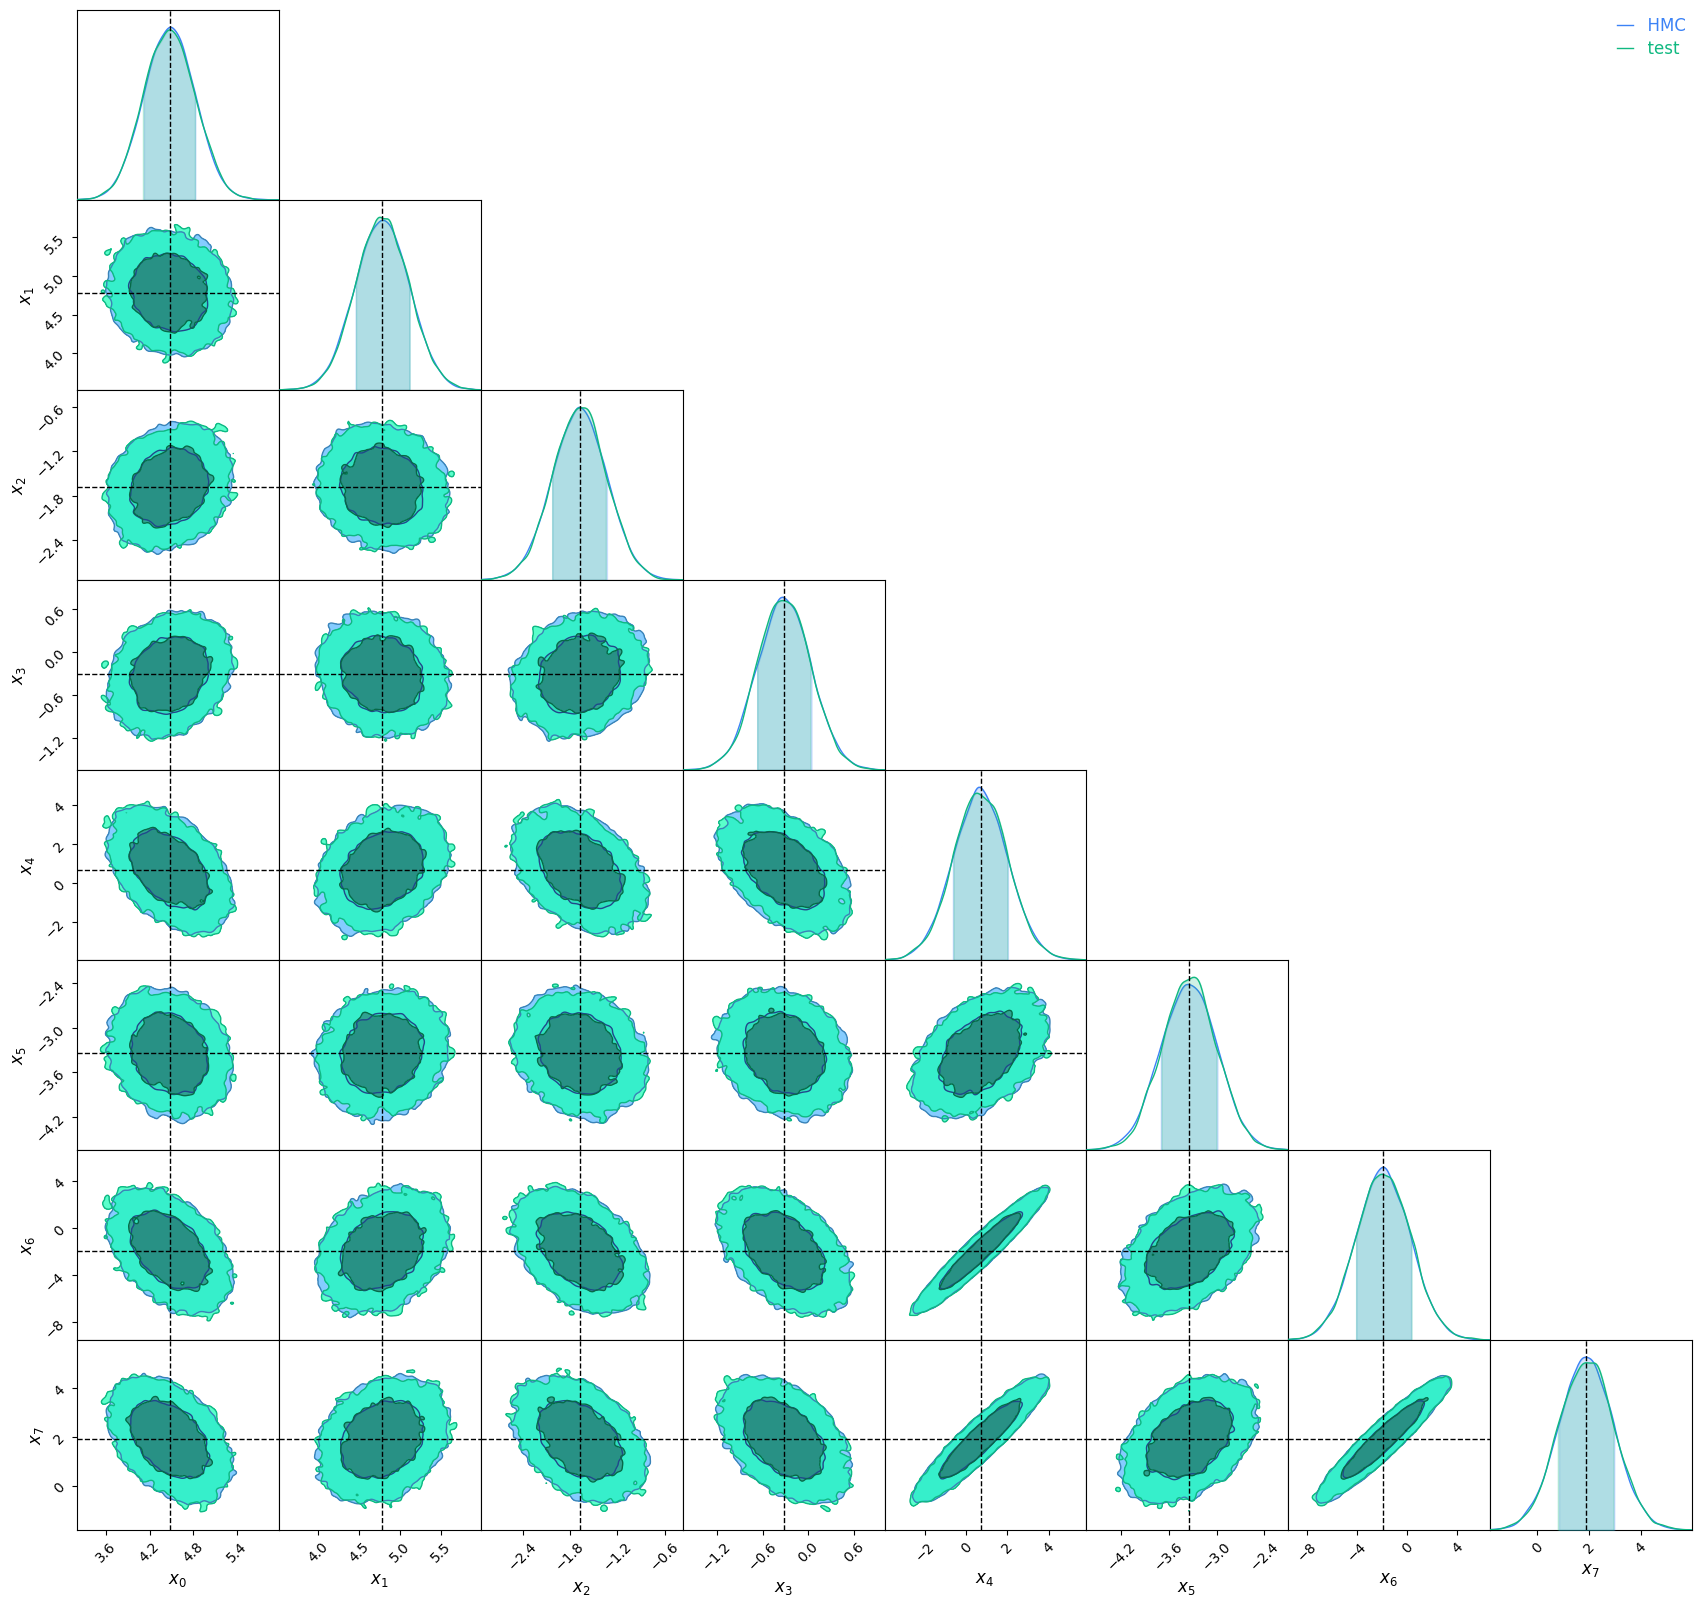

In [32]:
df_test = pd.DataFrame(test_samples['x'], columns=x_labels)
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='HMC'))
c.add_chain(Chain(samples=df_test, name='test'))
c.add_truth(Truth(location={name: val for name, val in zip(x_labels, x_mean)}))
fig = c.plotter.plot()